In [1]:
import pandas as pd
import numpy as np
import gradio as gr

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv("bbc_data.csv")
data.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [3]:
data.rename(columns={
    'data': 'text',
    'labels': 'label'
}, inplace=True)

In [4]:
# Remove null values
data.dropna(inplace=True)

# Convert labels to string (safe for ML)
data['label'] = data['label'].astype(str)


In [5]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

data['clean_text'] = data['text'].apply(preprocess)
data.head()


,text,label,clean_text
0,Musicians to tackle US red tape Musicians gro...,entertainment,musicians tackle us red tape musicians groups ...
1,"U2s desire to be number one U2, who have won ...",entertainment,desire number one three prestigious grammy awa...
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment,rocker doherty fight rock singer pete doherty ...
3,Snicket tops US box office chart The film ada...,entertainment,snicket tops us box office chart film adaptati...
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment,oceans twelve raids box office oceans crime ca...


In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['clean_text'])
y = data['label']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
model = MultinomialNB()
model.fit(X_train, y_train)


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [9]:
y_pred = model.predict(X_test)


In [10]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9775280898876404


In [11]:
print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

     business       0.98      0.95      0.97       103
entertainment       1.00      0.96      0.98        84
     politics       0.95      0.99      0.97        80
        sport       1.00      0.99      0.99        98
         tech       0.95      1.00      0.98        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



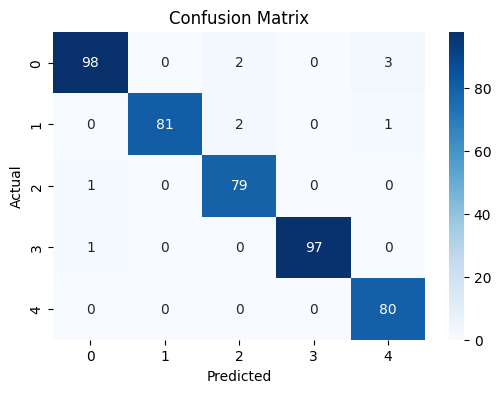

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [13]:
new_text = ["The government passed a new law"]
clean_text = preprocess(new_text[0])
vector = vectorizer.transform([clean_text])
prediction = model.predict(vector)

print("Predicted class:", prediction[0])


Predicted class: politics


In [14]:
def predict_with_confidence(text):
    if not text.strip():
        return "⚠️ Please enter some text."

    try:
        vec = vectorizer.transform([text])
        pred = model.predict(vec)[0]
        prob = model.predict_proba(vec).max()

        return f"{pred} (Confidence: {prob:.2f})"

    except Exception as e:
        return "❌ Prediction failed"



In [15]:
def explain_prediction(text):
    if not text.strip():
        return "No keywords"

    try:
        vec = vectorizer.transform([text])
        feature_names = vectorizer.get_feature_names_out()
        weights = vec.toarray()[0]

        top_idx = weights.argsort()[-5:][::-1]
        keywords = [feature_names[i] for i in top_idx if weights[i] > 0]

        return ", ".join(keywords) if keywords else "No important keywords found"

    except Exception as e:
        return "Keyword extraction failed"


In [16]:
import gradio as gr

with gr.Blocks(theme=gr.themes.Soft()) as demo:

    gr.Markdown("## 🧠 Document Classification System")
    gr.Markdown("**Enter a document below to predict its category.**")

    with gr.Column():
        input_text = gr.Textbox(
            lines=8,
            label="📄 Input Document",
            placeholder="Paste or type your document text here..."
        )

        with gr.Row():
            classify_btn = gr.Button("🔍 Classify Document", variant="primary")
            clear_btn = gr.Button("🧹 Clear", variant="secondary")

        output_label = gr.Textbox(
            label="📌 Predicted Category",
            interactive=False
        )

        keywords_output = gr.Textbox(
            label="🔑 Important Keywords",
            interactive=False
        )

    gr.Markdown("""
    **Model Details**
    - Feature Extraction: Bag-of-Words  
    - Classifier: Multinomial Naive Bayes  
    - Interface: Gradio  
    """)

    classify_btn.click(
        fn=lambda x: (
            predict_with_confidence(x),
            explain_prediction(x)
        ),
        inputs=input_text,
        outputs=[output_label, keywords_output]
    )

    clear_btn.click(
        fn=lambda: ("", "", ""),
        outputs=[input_text, output_label, keywords_output]
    )

demo.launch()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3376\289333431.py:3: UserWarning: The parameters have been moved from the Blocks constructor to the launch() method in Gradio 6.0: theme. Please pass these parameters to launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
